<a href="https://colab.research.google.com/github/Poorya0071/Image-classification/blob/main/Transfer_Learning_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Study

This project aims to evaluate the effectiveness of a pretrained model from TensorHub by comparing its performance to other models. The results of this comparison will provide insight into the capabilities of the pretrained model and its potential utility for various tasks.*italicized text*

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt

In [54]:
tf.__version__

'2.9.2'

In [1]:
import tensorflow_datasets.public_api as tfds


In [2]:
datasets_list = tfds.list_builders() 

### Let's upload the flower dataset, adn split it to train and valid dataset.

In [3]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [4]:
dataset_info.features


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

In [5]:
# get class_names
class_names = dataset_info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

### We will select a single sample from the dataset and inspect the characteristics of the data. Specifically, we will determine the data type and shape of the sample. This information will be useful in understanding the structure of the dataset and ensuring that it is appropriate for the intended purpose.

In [6]:
train_one_sample = training_set.take(1)

In [7]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (333, 500, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 2
  Class name (str form): tulips
        


### A preprocessing function will be defined to transform the size and format of the data in order to prepare it for use with deep learning algorithms. This function will likely involve resizing the data and possibly converting it to a specific format that is compatible with the chosen deep learning model. The goal of this preprocessing step is to ensure that the data is in a form that can be effectively utilized by the deep learning algorithms for the task at hand.

In [8]:
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32)/255, label # return (float32_image, label) tuple

In [9]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")


Image before preprocessing:
 [[[ 93 122  30]
  [ 90 118  31]
  [ 88 118  28]
  ...
  [247  77  78]
  [253  87  87]
  [255  76  75]]

 [[ 98 125  30]
  [ 95 124  32]
  [ 96 125  32]
  ...
  [247  81  83]
  [250  86  84]
  [252  71  64]]]...,
Shape: (333, 500, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[0.36222863 0.47339335 0.12065084]
  [0.38932073 0.49603465 0.12440875]
  [0.44994053 0.5188505  0.18506865]
  ...
  [0.811333   0.00368276 0.00526479]
  [0.9869666  0.27835765 0.28736892]
  [0.9923058  0.32219484 0.31731558]]

 [[0.38764647 0.49593282 0.11631973]
  [0.4344004  0.53441554 0.14408584]
  [0.48117998 0.5441804  0.19613488]
  ...
  [0.9261731  0.06054506 0.09054101]
  [0.9946857  0.29256618 0.32007042]
  [0.9904571  0.28474241 0.2665086 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


# Map the train and test datasets to preprocessing function.

In [10]:
train_data = training_set.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = validation_set.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [12]:
# from tensorflow.keras import layers

# # Create base model
# input_shape = (224, 224, 3)
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable = False # freeze base model layers

# # Create Functional model 
# inputs = layers.Input(shape=input_shape, name="input_layer")
# # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# # x = layers.Rescaling(1./255)(x)
# x = base_model(inputs, training=False) # set base_model to inference mode only
# x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
# x = layers.Dense(len(class_names))(x) # want one output neuron per class
# # Separate activation of output layer so we can output float32 activations
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# model = tf.keras.Model(inputs, outputs)

# # Compile the model
# model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=["accuracy"])

# Transfer Learning

In [14]:
import tensorflow_hub as hub
IMAGE_SHAPE = (224, 224)
def create_model(model_url, num_classes=10):
  
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [15]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
efficientnet_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/classification/2"
inception_v1 = "https://tfhub.dev/google/imagenet/inception_v1/classification/5"
inception_resnet_v2 = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
mobilenet_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"
resnet_v2_50 = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"
efficientnet_B5 = "https://tfhub.dev/tensorflow/efficientnet/b5/classification/1"

In [16]:
efficientnet_B5_model = create_model(efficientnet_B5, num_classes=5)

# Compile
efficientnet_B5_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [17]:
efficientnet_B5_model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
92/92 [==============================] - 56s 294ms/step - loss: 1.5847 - accuracy: 0.4315 - val_loss: 1.5644 - val_accuracy: 0.4932
Epoch 2/10
92/92 [==============================] - 24s 249ms/step - loss: 1.5451 - accuracy: 0.5078 - val_loss: 1.5290 - val_accuracy: 0.4973
Epoch 3/10
92/92 [==============================] - 23s 250ms/step - loss: 1.5092 - accuracy: 0.5177 - val_loss: 1.4962 - val_accuracy: 0.5177
Epoch 4/10
92/92 [==============================] - 23s 248ms/step - loss: 1.4762 - accuracy: 0.5303 - val_loss: 1.4661 - val_accuracy: 0.5286
Epoch 5/10
92/92 [==============================] - 24s 255ms/step - loss: 1.4456 - accuracy: 0.5446 - val_loss: 1.4377 - val_accuracy: 0.5368
Epoch 6/10
92/92 [==============================] - 23s 248ms/step - loss: 1.4170 - accuracy: 0.5582 - val_loss: 1.4113 - val_accuracy: 0.5490
Epoch 7/10
92/92 [==============================] - 23s 248ms/step - loss: 1.3903 - accuracy: 0.5674 - val_loss: 1.3866 - val_accuracy: 0.5572

In [18]:
resnet_v2_50_model = create_model(resnet_v2_50, num_classes=5)

# Compile
resnet_v2_50_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [19]:
resnet_v2_50_model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
92/92 [==============================] - 16s 128ms/step - loss: 0.8753 - accuracy: 0.7057 - val_loss: 0.4776 - val_accuracy: 0.8311
Epoch 2/10
92/92 [==============================] - 10s 106ms/step - loss: 0.4218 - accuracy: 0.8529 - val_loss: 0.4299 - val_accuracy: 0.8433
Epoch 3/10
92/92 [==============================] - 10s 106ms/step - loss: 0.3412 - accuracy: 0.8825 - val_loss: 0.3689 - val_accuracy: 0.8774
Epoch 4/10
92/92 [==============================] - 11s 105ms/step - loss: 0.2918 - accuracy: 0.9002 - val_loss: 0.3614 - val_accuracy: 0.8815
Epoch 5/10
92/92 [==============================] - 10s 106ms/step - loss: 0.2551 - accuracy: 0.9125 - val_loss: 0.3555 - val_accuracy: 0.8828
Epoch 6/10
92/92 [==============================] - 10s 106ms/step - loss: 0.2359 - accuracy: 0.9142 - val_loss: 0.3480 - val_accuracy: 0.8869
Epoch 7/10
92/92 [==============================] - 10s 106ms/step - loss: 0.2153 - accuracy: 0.9285 - val_loss: 0.3608 - val_accuracy: 0.8815

In [20]:
mobilenet_v3_model = create_model(mobilenet_v3, num_classes=5)

# Compile
mobilenet_v3_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [21]:
mobilenet_v3_model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
92/92 [==============================] - 11s 69ms/step - loss: 0.7496 - accuracy: 0.7381 - val_loss: 0.4005 - val_accuracy: 0.8529
Epoch 2/10
92/92 [==============================] - 5s 52ms/step - loss: 0.3038 - accuracy: 0.8941 - val_loss: 0.3115 - val_accuracy: 0.8924
Epoch 3/10
92/92 [==============================] - 5s 53ms/step - loss: 0.2282 - accuracy: 0.9234 - val_loss: 0.2846 - val_accuracy: 0.9033
Epoch 4/10
92/92 [==============================] - 5s 53ms/step - loss: 0.1875 - accuracy: 0.9418 - val_loss: 0.2755 - val_accuracy: 0.9114
Epoch 5/10
92/92 [==============================] - 5s 53ms/step - loss: 0.1555 - accuracy: 0.9527 - val_loss: 0.2780 - val_accuracy: 0.9019
Epoch 6/10
92/92 [==============================] - 5s 53ms/step - loss: 0.1361 - accuracy: 0.9612 - val_loss: 0.2767 - val_accuracy: 0.9087
Epoch 7/10
92/92 [==============================] - 5s 53ms/step - loss: 0.1210 - accuracy: 0.9642 - val_loss: 0.2863 - val_accuracy: 0.9005
Epoch 8/10
9

In [22]:
inception_v3_model = create_model(inception_v3, num_classes=5)

# Compile
inception_v3_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [23]:
inception_v3_model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
92/92 [==============================] - 17s 120ms/step - loss: 0.9285 - accuracy: 0.6884 - val_loss: 0.5722 - val_accuracy: 0.7970
Epoch 2/10
92/92 [==============================] - 9s 90ms/step - loss: 0.4529 - accuracy: 0.8416 - val_loss: 0.4971 - val_accuracy: 0.8270
Epoch 3/10
92/92 [==============================] - 9s 90ms/step - loss: 0.3637 - accuracy: 0.8730 - val_loss: 0.4639 - val_accuracy: 0.8379
Epoch 4/10
92/92 [==============================] - 9s 91ms/step - loss: 0.3081 - accuracy: 0.8931 - val_loss: 0.4759 - val_accuracy: 0.8256
Epoch 5/10
92/92 [==============================] - 9s 90ms/step - loss: 0.2723 - accuracy: 0.9026 - val_loss: 0.4574 - val_accuracy: 0.8256
Epoch 6/10
92/92 [==============================] - 9s 91ms/step - loss: 0.2424 - accuracy: 0.9145 - val_loss: 0.4402 - val_accuracy: 0.8351
Epoch 7/10
92/92 [==============================] - 9s 91ms/step - loss: 0.2317 - accuracy: 0.9159 - val_loss: 0.4364 - val_accuracy: 0.8488
Epoch 8/10


In [24]:
inception_resnet_v2_model = create_model(inception_resnet_v2, num_classes=5)

# Compile
inception_resnet_v2_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [25]:
inception_resnet_v2_model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
92/92 [==============================] - 36s 248ms/step - loss: 0.9419 - accuracy: 0.6996 - val_loss: 0.4656 - val_accuracy: 0.8243
Epoch 2/10
92/92 [==============================] - 20s 216ms/step - loss: 0.4546 - accuracy: 0.8450 - val_loss: 0.3968 - val_accuracy: 0.8556
Epoch 3/10
92/92 [==============================] - 21s 218ms/step - loss: 0.3837 - accuracy: 0.8631 - val_loss: 0.3934 - val_accuracy: 0.8529
Epoch 4/10
92/92 [==============================] - 20s 215ms/step - loss: 0.3338 - accuracy: 0.8784 - val_loss: 0.3903 - val_accuracy: 0.8597
Epoch 5/10
92/92 [==============================] - 20s 217ms/step - loss: 0.2978 - accuracy: 0.8948 - val_loss: 0.4185 - val_accuracy: 0.8583
Epoch 6/10
92/92 [==============================] - 21s 218ms/step - loss: 0.2761 - accuracy: 0.9012 - val_loss: 0.3886 - val_accuracy: 0.8719
Epoch 7/10
92/92 [==============================] - 21s 219ms/step - loss: 0.2545 - accuracy: 0.9114 - val_loss: 0.3961 - val_accuracy: 0.8706

In [26]:
inception_v1_model = create_model(inception_v1, num_classes=5)

# Compile
inception_v1_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [27]:
inception_v1_model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
92/92 [==============================] - 11s 74ms/step - loss: 0.6906 - accuracy: 0.7568 - val_loss: 0.4262 - val_accuracy: 0.8460
Epoch 2/10
92/92 [==============================] - 5s 51ms/step - loss: 0.3580 - accuracy: 0.8740 - val_loss: 0.3218 - val_accuracy: 0.8760
Epoch 3/10
92/92 [==============================] - 5s 52ms/step - loss: 0.2980 - accuracy: 0.9005 - val_loss: 0.3209 - val_accuracy: 0.8896
Epoch 4/10
92/92 [==============================] - 5s 52ms/step - loss: 0.2737 - accuracy: 0.9050 - val_loss: 0.2916 - val_accuracy: 0.8896
Epoch 5/10
92/92 [==============================] - 5s 51ms/step - loss: 0.2439 - accuracy: 0.9179 - val_loss: 0.2851 - val_accuracy: 0.8951
Epoch 6/10
92/92 [==============================] - 5s 51ms/step - loss: 0.2202 - accuracy: 0.9227 - val_loss: 0.2859 - val_accuracy: 0.8869
Epoch 7/10
92/92 [==============================] - 5s 52ms/step - loss: 0.2077 - accuracy: 0.9285 - val_loss: 0.2830 - val_accuracy: 0.8951
Epoch 8/10
9

In [28]:
efficientnet_v2_model = create_model(efficientnet_v2, num_classes=5)

# Compile
efficientnet_v2_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [29]:
efficientnet_v2_model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
92/92 [==============================] - 28s 184ms/step - loss: 1.8410 - accuracy: 0.9087 - val_loss: 0.6498 - val_accuracy: 0.9523
Epoch 2/10
92/92 [==============================] - 15s 160ms/step - loss: 0.7695 - accuracy: 0.9605 - val_loss: 1.1757 - val_accuracy: 0.9428
Epoch 3/10
92/92 [==============================] - 16s 163ms/step - loss: 0.7641 - accuracy: 0.9659 - val_loss: 0.9991 - val_accuracy: 0.9360
Epoch 4/10
92/92 [==============================] - 16s 165ms/step - loss: 0.6096 - accuracy: 0.9687 - val_loss: 1.9818 - val_accuracy: 0.9401
Epoch 5/10
92/92 [==============================] - 16s 165ms/step - loss: 0.5744 - accuracy: 0.9724 - val_loss: 1.0232 - val_accuracy: 0.9632
Epoch 6/10
92/92 [==============================] - 18s 189ms/step - loss: 0.5236 - accuracy: 0.9765 - val_loss: 1.3893 - val_accuracy: 0.9591
Epoch 7/10
92/92 [==============================] - 16s 163ms/step - loss: 0.5156 - accuracy: 0.9782 - val_loss: 1.3584 - val_accuracy: 0.9619

In [30]:
efficientnet_model = create_model(efficientnet_url, num_classes=5)

# Compile
efficientnet_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [31]:
efficientnet_model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
92/92 [==============================] - 18s 93ms/step - loss: 0.6663 - accuracy: 0.7895 - val_loss: 0.3775 - val_accuracy: 0.9033
Epoch 2/10
92/92 [==============================] - 8s 76ms/step - loss: 0.3161 - accuracy: 0.9135 - val_loss: 0.2806 - val_accuracy: 0.9142
Epoch 3/10
92/92 [==============================] - 8s 76ms/step - loss: 0.2414 - accuracy: 0.9332 - val_loss: 0.2433 - val_accuracy: 0.9223
Epoch 4/10
92/92 [==============================] - 8s 77ms/step - loss: 0.1991 - accuracy: 0.9455 - val_loss: 0.2182 - val_accuracy: 0.9305
Epoch 5/10
92/92 [==============================] - 8s 77ms/step - loss: 0.1716 - accuracy: 0.9567 - val_loss: 0.2052 - val_accuracy: 0.9346
Epoch 6/10
92/92 [==============================] - 8s 77ms/step - loss: 0.1498 - accuracy: 0.9636 - val_loss: 0.1922 - val_accuracy: 0.9360
Epoch 7/10
92/92 [==============================] - 8s 76ms/step - loss: 0.1317 - accuracy: 0.9717 - val_loss: 0.1884 - val_accuracy: 0.9346
Epoch 8/10
9

In [32]:
import matplotlib.pyplot as plt


# Prediction Function

In [33]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [34]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

# Simple Conv2D model

In [36]:
model_1 = tf.keras.Sequential([    
    layers.Conv2D(32, 5, activation="relu", input_shape=(224, 224, 3)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Dropout(0.25),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Dropout(0.25),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Dropout(0.25),
    
    layers.Flatten(),
    
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(), 
    layers.Dropout(0.5),
  
    layers.Dense(5, activation="softmax") 
])

model_1.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [37]:
model_1.fit(train_data,
                        epochs=25,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/25
92/92 [==============================] - 13s 106ms/step - loss: 1.7537 - accuracy: 0.4860 - val_loss: 2.9748 - val_accuracy: 0.2166
Epoch 2/25
92/92 [==============================] - 9s 88ms/step - loss: 1.1934 - accuracy: 0.5756 - val_loss: 2.3037 - val_accuracy: 0.3011
Epoch 3/25
92/92 [==============================] - 9s 88ms/step - loss: 0.9735 - accuracy: 0.6567 - val_loss: 2.0446 - val_accuracy: 0.2847
Epoch 4/25
92/92 [==============================] - 9s 88ms/step - loss: 0.8083 - accuracy: 0.7112 - val_loss: 1.7018 - val_accuracy: 0.4019
Epoch 5/25
92/92 [==============================] - 9s 89ms/step - loss: 0.6483 - accuracy: 0.7691 - val_loss: 1.1044 - val_accuracy: 0.5954
Epoch 6/25
92/92 [==============================] - 9s 88ms/step - loss: 0.5002 - accuracy: 0.8174 - val_loss: 1.0038 - val_accuracy: 0.6349
Epoch 7/25
92/92 [==============================] - 9s 91ms/step - loss: 0.3634 - accuracy: 0.8658 - val_loss: 1.1491 - val_accuracy: 0.6294
Epoch 8/25


1/1 [==============================] - 0s 32ms/step


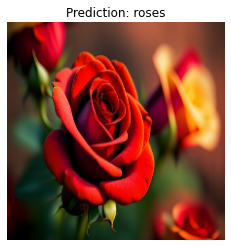

In [48]:
pred_and_plot(model_1, '/content/360_F_558733520_fvvk5SUezfwJpsydi0lBHFzZVa5abVmk.jpg', class_names)

1/1 [==============================] - 0s 54ms/step


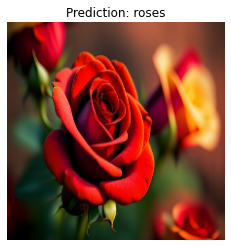

In [49]:
pred_and_plot(efficientnet_v2_model, '/content/360_F_558733520_fvvk5SUezfwJpsydi0lBHFzZVa5abVmk.jpg', class_names)

1/1 [==============================] - 0s 70ms/step


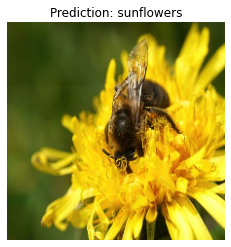

In [44]:
pred_and_plot(model_1, '/content/dfas.jpg', class_names)

1/1 [==============================] - 2s 2s/step


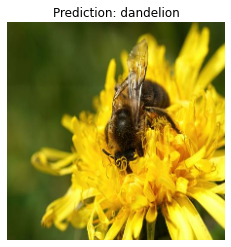

In [45]:
pred_and_plot(efficientnet_v2_model, '/content/dfas.jpg', class_names)

# Conclusion

Based on the evaluation results, it appears that the simple Conv2D model is not able to accurately classify images with complex features, such as the presence of multiple objects in a single image. This is demonstrated by the model's incorrect prediction for the second image, which depicts both a dandelion and a bee. In contrast, the pretrained models, including efficientnet_v2, demonstrate higher accuracy, with efficientnet_v2 achieving a classification accuracy of over 96%. This suggests that pretrained models are more effective at handling complex images and may be more suitable for tasks involving such data. Overall, the comparison of the pretrained models suggests that efficientnet_v2 is the most effective at image classification in this context.